# 1.Cam_Pretrained.ipynb 說明
本 notebook 主要教學如何利用預訓練模型（如 ResNet、VGG 等）實作 Class Activation Mapping（CAM，類別激活圖），用於視覺化 CNN 模型在影像分類時「關注」的區域。內容重點如下：
1. **預訓練模型載入**：使用 torchvision 等套件載入 ImageNet 預訓練的 CNN 模型。
2. **資料前處理**：對輸入影像進行 resize、normalize 等處理，符合模型需求。
3. **前向推論與特徵提取**：將影像輸入模型，取得分類結果與中間層特徵。
4. **CAM 計算與視覺化**：根據最後卷積層的特徵圖與分類權重，計算出 CAM，並將其疊加在原圖上，視覺化模型「看」到的重點區域。
5. **應用與延伸**：可用於模型解釋、錯誤分析、醫學影像等領域。
本 notebook 適合用於理解深度學習模型的可解釋性（Explainable AI），並學習如何用 PyTorch 實作 CAM 技術。

# Cam 實作

* 論文參考網址：http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

In [1]:
# import package
import os
import cv2
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

# 一、load Data

## 1. 讀取圖片

In [3]:
img_size = 224

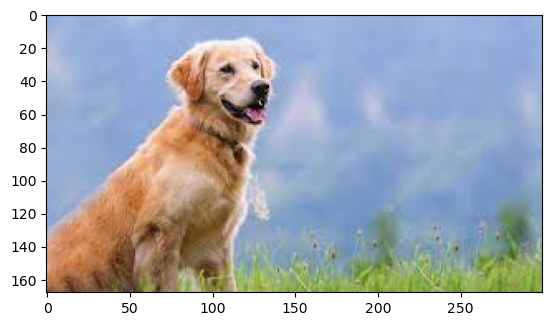

In [4]:
Dogimgfile = './Dog.jpg' #圖片路徑
img = cv2.imread(Dogimgfile)

plt.imshow(img[:,:,::-1])

## 2. 圖片的預處理（根據訓練完的模型的預處理方式來進行）

In [5]:
# 圖片的預處理
preprocess_fn = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((img_size,img_size)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

## 3. 將imagenet的數字對應標籤的dictionary讀進來

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [6]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    label_dict = eval(f.read())

## 4. 使用在imagenet-1k訓練好的resnet50模型來預測圖片

/Users/michael.c/opt/anaconda3/envs/AIF_course/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/michael.c/opt/anaconda3/envs/AIF_course/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/michael.c/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 47.5MB/s]


Text(0.5, 1.0, 'golden retriever')

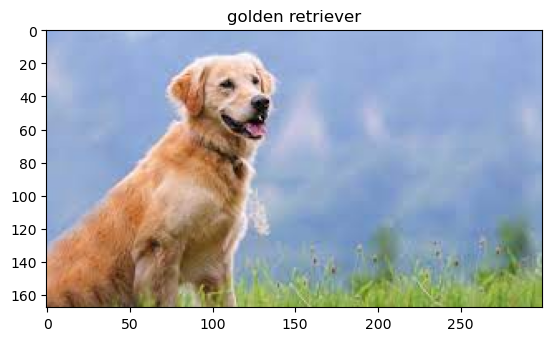

In [7]:
softmax_output = nn.Softmax(dim=1)

# 1. 輸入想要檢測的模型，這裡以訓練imagenet的resnet50模型做完範例
cnn_model = models.resnet50(pretrained=True)
cnn_model.to(device)
# Set model to eval mode
cnn_model.eval()

# 2. 讀取圖片，並做預處理
Img = cv2.imread(Dogimgfile)                # image read
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)  # BGR to RGB

ImgTest = preprocess_fn(Img)                # preprocessing
ImgTest = torch.unsqueeze(ImgTest, 0)       # (3,224,224) -> (1,3,224,224)
ImgTest = ImgTest.to(device)                # to gpu mode

# 3. 模型預測
Result = cnn_model(ImgTest)                 # Predict images

# 4. 輸出softmax的結果，並將最大的output的argmax取出來
sm_Result = softmax_output(Result)          # softmax output
sm_Result = sm_Result.data.cpu().numpy()
arg_sm = sm_Result[0].argmax()

# 5. 顯示出圖片，並將預測結果顯示出來
plt.imshow(Img)
plt.title(label_dict[arg_sm])

# 二、CAM(Class Activation Mapping)

* CAM 的思想非常的直覺，我們先從神經網路是如何分類下手。如下圖中，我們想要知道該影像分類為何，最後一層的卷積層生成的每張特徵圖經過 `GAP` 變成一個像素，該像素包含了整張特徵圖的訊息，最後再將一維的像素陣列乘以`權重 w `後，經過 softmax 知道`Dog`該分類的值最大，所以這張影像被分為 `Dog`。

* 接著，我們往回推模型，經過 `GAP` 後的像素陣列會乘以`權重 w`，`權重 w` 的值越大代表該像素所代表的影像影響越大。而既然 `w `是指每張特徵圖(這裡的特徵圖指的就是最後一層convolution layer的輸出)可以被分為 `Dog`的重要程度，不如把整張特徵圖的像素點皆乘以`權重 w `後疊加，便能夠依據每張特徵圖的重要性關注不同的區域。對應到該分類的`權重 w` 越大，該特徵圖影響越大；反之，權重越趨近於 0 的特徵圖越不重要。

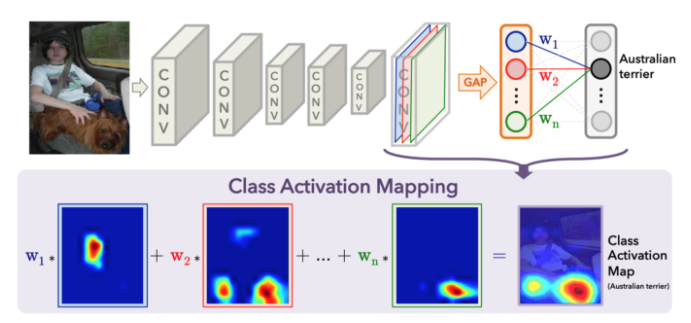

In [8]:
class Cam():
    def __init__(self, imgfile, model, img_size, label_dict, output_model_layer):
        self.imgfile = imgfile
        self.model = model
        self.model.eval()
        self.img_size = img_size
        self.label_dict = label_dict
        self.fmap_block = []  # 特徵圖的結果, model feed forward的feature map output
        self.grad_block = []  # gradient的結果
        
        # Regist hook for gradient
        output_model_layer.register_forward_hook(self.__forward_hook)   # save feature map
        output_model_layer.register_backward_hook(self.__backward_hook) # save gradient output
        
    def ReadImage(self):
        img = cv2.imread(self.imgfile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR to RGB
        return img
    
    def processing_image(self):
        img = self.ReadImage()
        preprocess_fn = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((self.img_size,self.img_size)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        ImgTest = preprocess_fn(img)
        
        # (3,224,224) -> (1,3,224,224)
        ImgTest = torch.unsqueeze(ImgTest, 0)
        # to gpu mode
        ImgTest = ImgTest.to(device)
        return ImgTest
    
    def __backward_hook(self, module, grad_in, grad_out):
        self.grad_block.append(grad_out[0].detach()) # gradient output
    
    def __forward_hook(self, module, input, output):
        self.fmap_block.append(output)               # feature map output

    def cam(self):
        x = self.processing_image() # processing_image output result
        
        # 1. 模型預測，並儲存預測出來的結果
        Result = self.model(x)
        # 輸出softmax的結果，並將最大的output的argmax取出來
        arg_sm = np.argmax(Result.cpu().data.numpy())              
        pred_class_name = self.label_dict[arg_sm]     # 預測出來的標籤, top 1
        
        # 2. 取得GAP層與最後輸出層的權重
        class_weights = self.model.fc.weight             #取得GAP層的weight, 如：(1000, 2048)
        class_weights = class_weights.data.cpu().numpy() # Tensor gpu to numpy array
        
        # 3. Feed forward get feature map
        Feature_map = self.fmap_block[0].cpu().data.numpy().squeeze()
        print(Feature_map.shape)

        # 4. 將class weight的結果乘上Feature map上
        
        # 建立一個空的cam, 大小就是最後一層輸出的長與寬，如：(7,7), Feture_map1 *w1 + Feature_map2 *w2 + ... + Feature_mapn *wn
        cam = np.zeros(dtype = np.float32, shape = Feature_map.shape[1:3]) # (7,7)
        
        # use <pred_class> to choose which output label we want to visualize
        # 通常都以argmax(predsoutput)來參考
        for i, w in enumerate(class_weights[arg_sm, :]):  # class_weights[arg_sm, :] -> 要拿出哪一個類別的class weight
                cam += w * Feature_map[i, :, :]
        
        #將數值normalize到0,1之間
        heatmap = cam / (np.max(cam) - np.min(cam))
        return heatmap, pred_class_name
    

    def plot_heatmap(self):
        # 圖像讀取，並resize
        img = self.ReadImage()
        img = cv2.resize(img,(self.img_size, self.img_size))
        
        # 取得Cam的結果跟預測出來的class name
        heatmap, pred_class_name = self.cam()
        
        # 將heatmap 的數值從 (0,1) 變成 (0,255)
        heatmap = np.uint8(255 * heatmap)
        
        # heatmap resize
        # (7,7) -> (224,224)
        jet_heatmap = cv2.resize(heatmap,(self.img_size, self.img_size))

        plt.figure(figsize=(15, 5))
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title("Raw Image")

        plt.subplot(1,3,2)
        plt.imshow(img,alpha = 0.6)
        plt.imshow(jet_heatmap, cmap='jet', alpha=0.4)
        plt.title("Predict Result = %s"%(pred_class_name))

        plt.subplot(1,3,3)
        plt.imshow(jet_heatmap, cmap='jet')
        plt.title("Attention map")
        
        

In [9]:
# 1. 輸入想要檢測的模型，這裡以訓練imagenet的resnet50模型做完範例
cnn_model = models.resnet50(pretrained=True)
cnn_model.to(device)
print(cnn_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

(2048, 7, 7)
(2048, 7, 7)


/Users/michael.c/opt/anaconda3/envs/AIF_course/lib/python3.10/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


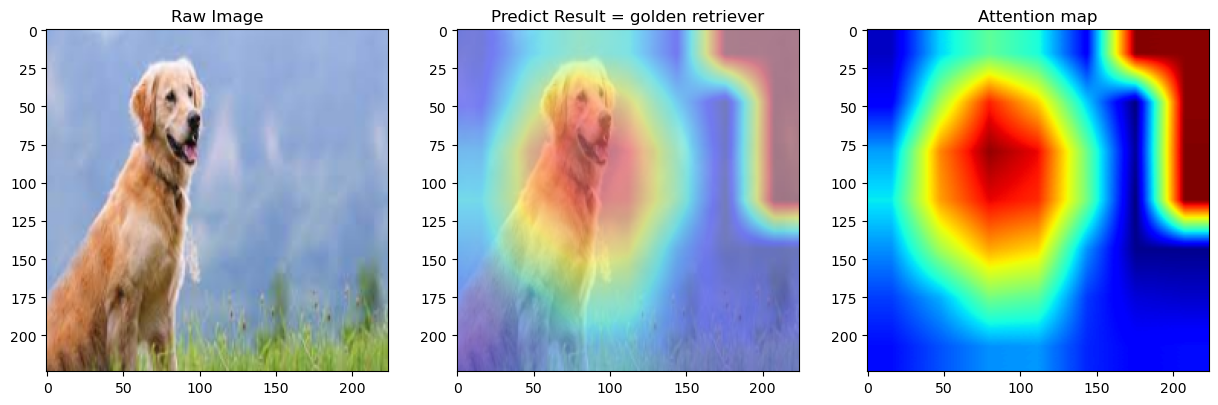

In [10]:
CAM = Cam(imgfile = Dogimgfile, 
          model = cnn_model, 
          img_size = img_size, 
          label_dict = label_dict, 
          output_model_layer = cnn_model.layer4[2])

outputlayer, outputname = CAM.cam()
CAM.plot_heatmap()